Our data starts from 10 October 2010 and ends in 18 April 2019. Our backtest will start from 01 January 2020 untill today.

In [ ]:
#Load our libraries
import pandas as pd
import numpy  as np
from   sklearn.model_selection import TimeSeriesSplit,cross_val_score
from   sklearn.linear_model    import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Define the forecast horizon
look_ahead          = 24
#Read in the data
data                = pd.read_csv('Market Data EURUSD MA Cross As Series.csv')
#Drop the last 4 years
data                =  data.iloc[:(-24 * 365 * 4),:]
data.reset_index(drop=True,inplace=True)
#Label the data
data['Target']      = data['Close'].shift(-look_ahead)
data['MA 5 Target']      = data['MA 5'].shift(-look_ahead)
data['MA 5 Close Target']      = data['Target'] - data['MA 5 Target']
data['MA 60 Target']      = data['MA 60'].shift(-look_ahead)
data['MA 60 Close Target']      = data['Target'] - data['MA 60 Target']
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
data

Time     Open     High      Low    Close      MA 5  \
0      2010.10.22 01:00:00  1.39066  1.39124  1.38983  1.39063  1.391242   
1      2010.10.22 02:00:00  1.39061  1.39110  1.38921  1.39087  1.391118   
2      2010.10.22 03:00:00  1.39089  1.39361  1.39077  1.39277  1.391669   
3      2010.10.22 04:00:00  1.39278  1.39621  1.39171  1.39599  1.393109   
4      2010.10.22 05:00:00  1.39598  1.39700  1.39527  1.39601  1.394076   
...                    ...      ...      ...      ...      ...       ...   
52591  2019.04.18 10:00:00  1.12518  1.12573  1.12492  1.12543  1.126503   
52592  2019.04.18 11:00:00  1.12542  1.12585  1.12501  1.12520  1.126069   
52593  2019.04.18 12:00:00  1.12520  1.12541  1.12380  1.12406  1.125399   
52594  2019.04.18 13:00:00  1.12406  1.12539  1.12361  1.12497  1.125256   
52595  2019.04.18 14:00:00  1.12498  1.12510  1.12362  1.12434  1.124951   

          MA 60   Target  MA 5 Target  MA 5 Close Target  MA 60 Target  \
0      1.392190  1.40307     1.400072           0.002998      1.393456   
1      1.392147  1.40281     1.400985           0.001825      1.393762   
2      1.392167  1.40347     1.401813           0.001657      1.394081   
3      1.392293  1.40550     1.403042           0.002458      1.394455   
4      1.392415  1.40759     1.404558           0.003032      1.394886   
...         ...      ...          ...                ...           ...   
52591  1.129333  1.12468     1.124475           0.000205      1.126363   
52592  1.129197  1.12455     1.124500           0.000050      1.126303   
52593  1.129029  1.12444     1.124480          -0.000040      1.126242   
52594  1.128896  1.12443     1.124463          -0.000033      1.126183   
52595  1.128746  1.12465     1.124526           0.000124      1.126133   

       MA 60 Close Target  
0                0.009614  
1                0.009048  
2                0.009389  
3                0.011045  
4                0.012704  
...                   ...  
52591           -0.001683  
52592           -0.001753  
52593           -0.001802  
52594           -0.001753  
52595           -0.001483  

[52596 rows x 12 columns]

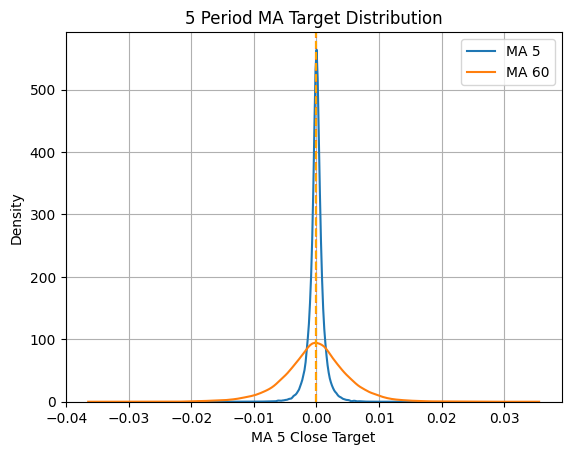

In [ ]:
#Let's look at the distributions of the 2 targets
sns.kdeplot(data['MA 5 Close Target'])
sns.kdeplot(data['MA 60 Close Target'])
plt.axvline(np.mean(data['MA 5 Close Target']),linestyle='--',color='red')
plt.axvline(np.mean(data['MA 60 Close Target']),linestyle='--',color='orange')
plt.title('5 Period MA Target Distribution')
plt.legend(['MA 5','MA 60'])
plt.grid()
plt.show()

In [ ]:
#Time series split object
tscv = TimeSeriesSplit(n_splits=5,gap=look_ahead)

In [ ]:
#Classical error
classical_error = []
epochs = 200
for i in np.arange(0,30):
  model = MLPRegressor(hidden_layer_sizes=(10,4),max_iter=epochs,early_stopping=False,solver='lbfgs')
  classical_error.append(np.mean(np.abs(cross_val_score(model,data.loc[:,['Open','High','Low','Close']],data.loc[:,'Target'],cv=tscv,scoring='neg_mean_squared_error'))))

In [ ]:
#MA Cross Over error
ma_5_error = []
for i in np.arange(0,1000):
  model = MLPRegressor(hidden_layer_sizes=(10,4),max_iter=epochs,early_stopping=False,solver='lbfgs')
  ma_5_error.append(np.mean(np.abs(cross_val_score(model,data.loc[:,['Open','High','Low','Close','MA 5']],data.loc[:,'MA 5 Target'],cv=tscv,scoring='neg_mean_squared_error'))))

KeyboardInterrupt: 

In [ ]:
#New error
ma_60_error = []
for i in np.arange(0,30):
  model = MLPRegressor(hidden_layer_sizes=(10,4),max_iter=10000,early_stopping=False,solver='lbfgs')
  ma_60_error.append(np.mean(np.abs(cross_val_score(model,data.loc[:,['Open','High','Low','Close','MA 60']],data.loc[:,'MA 60 Target'],cv=tscv,scoring='neg_mean_squared_error'))))

In [ ]:
#Which approach produces the lowest error?
plt.plot(classical_error)
plt.plot(ma_5_error)
plt.plot(ma_60_error)
plt.legend(['OHLC','MA 5 ','MA 60'])
plt.axhline(np.mean(classical_error),color='blue',linestyle='--')
plt.axhline(np.mean(ma_5_error),color='orange',linestyle='--')
plt.axhline(np.mean(ma_60_error),color='green',linestyle='--')
plt.grid()
plt.ylabel('Cross Validated Error')
plt.xlabel('Iteration')
plt.title('Comparing Different The Error Associated With Different Targets')
plt.legend(['OHLC Error','MA 5 Error','MA 60 Error'])
plt.show()

In [ ]:
!pip install onnx skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.4/298.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 

In [ ]:
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.neural_network import MLPRegressor

In [ ]:
ma_5_model = Ridge()
ma_5_model.fit(data[['Open','High','Low','Close','MA 5']],data['MA 5 Target'])

Ridge()

In [ ]:
ma_5_height_model = Ridge()
ma_5_height_model.fit(data[['Open','High','Low','Close','MA 5']],data['MA 5 Close Target'])

Ridge()

In [ ]:
ma_60_model = Ridge()
ma_60_model.fit(data[['Open','High','Low','Close','MA 60']],data['MA 60 Target'])

Ridge()

In [ ]:
ma_60_height_model = Ridge()
ma_60_height_model.fit(data[['Open','High','Low','Close','MA 60']],data['MA 60 Close Target'])

Ridge()

In [ ]:
initial_type = [('float_input', FloatTensorType([1, 5]))]
ma_5_onx = convert_sklearn(ma_5_model, initial_types=initial_type, target_opset=12 )
ma_60_onx = convert_sklearn(ma_60_model, initial_types=initial_type, target_opset=12 )

In [ ]:
initial_type = [('float_input', FloatTensorType([1, 5]))]
ma_5_height_onx = convert_sklearn(ma_5_height_model, initial_types=initial_type, target_opset=12 )
ma_60_height_onx = convert_sklearn(ma_60_height_model, initial_types=initial_type, target_opset=12 )

In [ ]:
onnx.save(ma_5_onx,'eurusd_ma_5_model.onnx')
onnx.save(ma_60_onx,'eurusd_ma_60_model.onnx')

In [ ]:
onnx.save(ma_5_height_onx,'eurusd_ma_5_height_model.onnx')
onnx.save(ma_60_height_onx,'eurusd_ma_60_height_model.onnx')